In [ ]:
# !pip install scikit-optimize
# !pip install sktime
# !pip install tensorflow --user
# !pip install statsmodels --user
# !pip install xgboost --user

In [1]:
# Basic libraries
import os
import random
import warnings
from datetime import datetime as dt

import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Stats
import scipy.stats as stats
from scipy.stats import jarque_bera, probplot, moment
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_breusch_godfrey, acorr_ljungbox, het_white
from statsmodels.tsa.stattools import acf, q_stat, adfuller

# Machine learning libraries
from sklearn.cluster import DBSCAN
from sklearn.ensemble import (AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor,
                              RandomForestRegressor)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, Matern, RBF, WhiteKernel
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression
from sklearn.metrics import (accuracy_score, mean_absolute_error, mean_absolute_percentage_error,
                             mean_squared_error, mean_squared_log_error, precision_score,
                             r2_score, recall_score)
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# XGBoost library
import xgboost as xgb

# LightGBM library
import lightgbm as lgb

# Set options
%matplotlib inline
warnings.filterwarnings("ignore")


Functions

In [2]:
# add date tiem features
def add_datetime_features(df):
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    df_copy = df.copy()
    
    # Extract year, month, and day information
    df_copy['year'] = df_copy.index.year
    df_copy['month'] = df_copy.index.month
    df_copy['day'] = df_copy.index.day
    df_copy['weekday'] = df_copy.index.weekday
    
    return df_copy

def generate_lagged_features(df, var, max_lag):
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    ts_data = df.copy()
    for t in range(1, max_lag + 1):
        ts_data[var + '_lag' + str(t)] = ts_data[var].shift(t)
    ts_data.dropna(inplace=True)

    return ts_data

def extract_column(df, column_name):
    extracted_column = df[column_name]
    remaining_df = df.drop(column_name, axis=1)
    return remaining_df, extracted_column

def scale_data(train_data, test_data, target_column):
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler() 

    
    train_X = train_data.drop(target_column, axis=1)
    train_Y = train_data[[target_column]]

    test_X = test_data.drop(target_column, axis=1)
    test_Y = test_data[[target_column]]

    train_X_scaled = scaler_X.fit_transform(train_X)
    train_Y_scaled = scaler_Y.fit_transform(train_Y)

    test_X_scaled = scaler_X.transform(test_X)
    test_Y_scaled = scaler_Y.transform(test_Y)
    
    train_data_scaled = pd.concat([pd.DataFrame(train_X_scaled, columns=train_X.columns, index=train_X.index),
                                pd.DataFrame(train_Y_scaled, columns=train_Y.columns, index=train_Y.index)], axis=1)
    test_data_scaled = pd.concat([pd.DataFrame(test_X_scaled, columns=test_X.columns, index=test_X.index),
                                pd.DataFrame(test_Y_scaled, columns=test_Y.columns, index=test_Y.index)], axis=1)


    return train_data_scaled, test_data_scaled, scaler_X, scaler_Y


def unscale_data(pred, actual, scaler):
    pred = scaler.inverse_transform(pred)
    actual = scaler.inverse_transform(actual)
    return pred, actual

def standardize_series(series):
    return StandardScaler().fit_transform(series.values.reshape(-1, 1))

def apply_dbscan_clustering(series_standardized, eps=0.5, min_samples=2):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    return dbscan.fit_predict(series_standardized)

def extract_outliers_from_clusters(series, clusters):
    """Identify the outliers (cluster label -1 indicates an outlier)"""
    return series[clusters == -1]

def cluster_based_outlier_detection(series):
    series_standardized = standardize_series(series)
    clusters = apply_dbscan_clustering(series_standardized, eps=0.15)
    outliers = extract_outliers_from_clusters(series, clusters)

    # Create a DataFrame with the same index as the original series
    outliers_df = pd.DataFrame(index=series.index)
    outliers_df['outliers'] = 0
    outliers_df.loc[outliers.index, 'outliers'] = 1

    return outliers_df
    
def prepare_time_series_data(df, var, max_lag, detect_outliers=False):
    # Generate lagged features
    lagged_data = generate_lagged_features(df, var, max_lag)
    
    # Add outlier features if detect_outliers is True
    if detect_outliers:
        series = df[var].pow(2)
        series.dropna(inplace=True)  #make sure no nan so outlier detection works

        outliers_df = cluster_based_outlier_detection(series)

        lagged_outliers = generate_lagged_features(outliers_df, 'outliers', max_lag)

        lagged_data = lagged_data.merge(lagged_outliers, left_index=True, right_index=True)


    # Add datetime features
    if not isinstance(lagged_data.index, pd.DatetimeIndex):
        lagged_data.index = pd.to_datetime(lagged_data.index)

    transformed_data = lagged_data
    # Drop rows with missing values
    transformed_data.dropna(inplace=True)

    return transformed_data

def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    # msle = mean_squared_log_error(y_true, y_pred)
    return {
        'rmse': rmse,
    }

def perform_grid_search(model, param_grid, X_train, Y_train, cv):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        scoring='neg_mean_squared_error',
        verbose=3,
        n_jobs=-1,
    )
    grid_search.fit(X_train, Y_train)
    best_model = grid_search.best_estimator_
    cv_results = grid_search.cv_results_
    mean_score = -np.mean(cv_results['mean_test_score'])
    std_score = np.std(cv_results['mean_test_score'])
    
    # Take the square root of the mean_score and std_score
    rmse_mean = np.sqrt(mean_score)
    rmse_std = np.sqrt(std_score)
    
    return best_model, rmse_mean, rmse_std

def train_best_model(best_model, X_train, Y_train):
    best_model.fit(X_train, Y_train)
    return best_model

def predict(model, X):
    return model.predict(X)

def reshape_and_unscale_predictions(preds, actuals, scaler_Y):
    # Reshape predictions and actual values for unscaling
    preds_reshaped = preds.reshape(-1, 1)
    actuals_reshaped = actuals.values.reshape(-1, 1)

    # Unscale the predictions and actual values
    unscaled_preds, unscaled_actuals = unscale_data(preds_reshaped, actuals_reshaped, scaler_Y)

    # Convert the unscaled predictions and actuals back to pandas Series
    unscaled_preds_series = pd.Series(unscaled_preds.squeeze(), index=actuals.index)
    unscaled_actuals_series = pd.Series(unscaled_actuals.squeeze(), index=actuals.index)

    return unscaled_preds_series, unscaled_actuals_series

def create_directory_if_not_exists(directory):
    os.makedirs(directory, exist_ok=True)
    
def save_plots_for_experiment(experiment, hypothesis, model_name, train_or_test, plot_type):
    # Create the necessary directories
    experiment_path = os.path.join(hypothesis, experiment, train_or_test)
    create_directory_if_not_exists(experiment_path)
    
    # Return the save path
    save_path = os.path.join(experiment_path, f"{model_name}_{plot_type}.png")
    return save_path

def model_pipeline(model, param_grid, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, model_name,experiment, show_plot=False):

    # Perform grid search
    best_model, rmean_error_train, std_error = perform_grid_search(model, param_grid, X_train, Y_train, tscv)
    
    print("\nBest model:", best_model)
    print("\nMean error:", rmean_error_train)
    print("\nStandard error:", std_error)
    
    # Train best model on all training data
    best_model_trained = train_best_model(best_model, X_train, Y_train)
    
    # Predict on train set
    train_preds = predict(best_model_trained, X_train)
    
    # Unscale and plot predictions vs actuals for train set
    unscaled_preds_series, unscaled_actuals_series = reshape_and_unscale_predictions(train_preds, Y_train, scaler_Y)
    save_path = save_plots_for_experiment(experiment, hypothesis, model_name, "train", "predictions_vs_actuals")
    plot_series(unscaled_actuals_series, unscaled_preds_series, title="Unscaled Predictions vs Actual Training Data", save_path=save_path, show_plot=show_plot)

    # Perform residual analysis for train set
    residuals_train = unscaled_actuals_series - unscaled_preds_series
    print("\nResidual analysis for train set:")
    save_path = save_plots_for_experiment(experiment, hypothesis, model_name, "train", "correlogram")
    plot_correlogram(residuals_train, save_path=save_path, show_plot=show_plot)
    save_path = save_plots_for_experiment(experiment, hypothesis, model_name, "train", "homoskedasticity_plot")
    residual_analysis(residuals_train, unscaled_preds_series, save_path=save_path)
    print("\nResiduals squared\n")
    save_path = save_plots_for_experiment(experiment, hypothesis, model_name, "train", "correlogram_squared")
    plot_correlogram(residuals_train.pow(2), save_path=save_path, show_plot=False)
    residual_analysis(residuals_train.pow(2), unscaled_preds_series.pow(2), save_path=None)
    
    # Predict on test set
    test_preds = predict(best_model_trained, X_test)
    rmse_test = np.sqrt(mean_squared_error(Y_test, test_preds))
    print("RMSE:", rmse_test)
    
    # Unscale and plot predictions vs actuals for test set
    unscaled_preds_series, unscaled_actuals_series = reshape_and_unscale_predictions(test_preds, Y_test, scaler_Y)
    save_path = save_plots_for_experiment(experiment, hypothesis, model_name, "test", "predictions_vs_actuals")
    plot_series(unscaled_actuals_series, unscaled_preds_series, title="Unscaled Predictions vs Actual Test Data", save_path=save_path, show_plot=show_plot)

    # Perform residual analysis for test set
    residuals_test = unscaled_actuals_series - unscaled_preds_series
    print("\nResidual analysis for test set:")
    save_path = save_plots_for_experiment(experiment, hypothesis, model_name, "test", "correlogram")
    plot_correlogram(residuals_test, save_path=save_path, show_plot=show_plot)
    save_path = save_plots_for_experiment(experiment, hypothesis, model_name, "test", "homoskedasticity_plot")
    residual_analysis(residuals_test, unscaled_preds_series, save_path=save_path)
    print("\nResiduals squared\n")
    save_path = save_plots_for_experiment(experiment, hypothesis, model_name, "test", "correlogram_squared")
    plot_correlogram(residuals_test.pow(2), title='Residuals Squared', save_path=save_path, show_plot=False)
    residual_analysis(residuals_test.pow(2), unscaled_preds_series.pow(2), save_path=None)

    return best_model_trained , rmean_error_train, rmse_test 

def plot_series(series1, series2, label1="Actual", label2="Predicted", title="Unscaled Predictions vs Actual Data", save_path=None, show_plot=False):
    fig, ax = plt.subplots()
    ax.plot(series1.index, series1, label=label1)
    ax.plot(series2.index, series2, label=label2, linestyle="--")
    ax.legend()
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title(title)
    if save_path:
        plt.savefig(save_path)
    plt.close()

def plot_correlogram(x, lags=None, title=None,save_path=None, show_plot=False):
    lags = min(10, int(len(x)/5)) if lags is None else lags
    x = x + np.random.normal(0, 1e-10, len(x)) ## Add noise to avoid non-invertibility
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    
    # Residuals plot
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    
    # Calculate Q-Stat and ADF statistics and display them on the residuals plot
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    
    # Probability plot
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    
    # Plot ACF and PACF on the bottom row of subplots
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    
    # Set x-axis labels for ACF and PACF plots
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')

    # Add title, remove box borders and adjust layout
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

    # Save plot to the specified path if provided
    if save_path:
        plt.savefig(save_path)

    # Close plot if not showing
    if not show_plot:
        plt.close()
    
    
def residual_analysis(residuals, y_pred, save_path=None):
    
    # Check for homoscedasticity
    print("Homoscedasticity scatter plot:")
    plt.scatter(y_pred, residuals)
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.axhline(y=0, color="r", linestyle="--")
    if save_path:
        plt.savefig(save_path)
    plt.close()

    # Perform Ljung-Box test for autocorrelation in residuals
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)  
    print("Ljung-Box test for autocorrelation in residuals:")
    print(lb_test)
    # Assess the p-value of the Ljung-Box test
    p_value = lb_test['lb_pvalue'][10]
    if p_value < 0.05:
        print("The Ljung-Box test suggests that there is autocorrelation in the residuals (p-value < 0.05).")
    else:
        print("The Ljung-Box test suggests that there is no significant autocorrelation in the residuals (p-value >= 0.05).")
    
    # Perform Jarque-Bera test for normality in residuals
    jb_test = jarque_bera(residuals)
    print("\nJarque-Bera test for normality in residuals:")
    if jb_test[1] < 0.05:
        print(f"Test statistic: {jb_test[0]}, p-value: {jb_test[1]}")
        print("The Jarque-Bera test suggests that the residuals are not normally distributed (p-value < 0.05).")
    else:
        print(f"Test statistic: {jb_test[0]}, p-value: {jb_test[1]}")
        print("The Jarque-Bera test suggests that the residuals are normally distributed (p-value >= 0.05).")    
        
def plot_rmse_comparison(results, hypothesis, experiment):
    fig = plt.figure()
    model_names = list(results.keys())
    train_rmse_values = [result['train_rmse'] for result in results.values()]
    test_rmse_values = [result['test_rmse'] for result in results.values()]

    ind = np.arange(len(model_names))  # the x locations for the groups
    width = 0.35  # the width of the bars

    fig.suptitle('Model Comparison')
    ax = fig.add_subplot(111)
    plt.bar(ind - width/2, train_rmse_values, width=width, label='Train Error')
    plt.bar(ind + width/2, test_rmse_values, width=width, label='Test Error')
    fig.set_size_inches(15, 8)
    plt.legend()
    ax.set_xticks(ind)
    ax.set_xticklabels(model_names)
    
    # Save the plot
    save_path = save_plots_for_experiment(experiment, hypothesis, "Results", "", "Model_Comparison")
    if save_path:
        plt.savefig(save_path)
   
def plot_all_experiment_results_comparison(df,hypothesis):
    sns.set_style('whitegrid')
    g = sns.catplot(x="Model", y="RMSE", hue="ErrorType", col="Experiment",
                    data=df, kind="bar", height=4, aspect=1, palette='Set1')

    for ax in g.axes.flat[1:]:
        sns.despine(ax=ax, left=True)
    for ax in g.axes.flat:
        ax.set_xlabel(ax.get_title())
        ax.set_title('')
        ax.margins(x=0.1)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

        # Add RMSE labels on top of each bar with two decimal places
        for c in ax.containers:
            ax.bar_label(c, label_type='edge', labels=[f"{v.get_height():.2f}" for v in c])
        ax.margins(y=0.2)

    plt.subplots_adjust(wspace=0, bottom=0.3, left=0.06)
    # Save the plot
    save_path = save_plots_for_experiment("", hypothesis, "Results", "", "All_Experiment_Comparison")
    plt.savefig(save_path)
    plt.show()
    plt.close()
    
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    return {
        'mae': mae,
        'rmse': rmse,
    }

# univaritae
## Simple models for benchmarking
def random_walk_forecast(start_point, forecast_length, return_mean, return_std, index):
    prediction = [start_point]

    for i in range(1, forecast_length):
        next_value = prediction[-1] * (1 + random.normalvariate(mu=return_mean, sigma=return_std))
        prediction.append(next_value)

    return pd.Series(prediction, index=index)

def calculate_benchmark_errors(series):
    mean_returns, std_returns = calculate_returns_stats(series)
    forecast_length = len(series)
    start_point = series[0]
    predictions = random_walk_forecast(start_point, forecast_length, mean_returns, std_returns, series.index)
    # print(predictions)
    evaluation_result = evaluate(series, predictions)
    # Return a dictionary containing the evaluation results for each baseline
    return {
        'Benchmark MAE': evaluation_result['mae'],
        'Benchmark RMSE': evaluation_result['rmse'],
    }

def calculate_returns_stats(time_series):
    # Calculate the returns
    returns = time_series / time_series.shift(1) - 1
    returns = returns.dropna()

    # Calculate mean returns and standard deviation of returns
    mean_returns = returns.mean()
    std_returns = returns.std()

    return mean_returns, std_returns

# multivariate
def random_walk_forecast_multivariate(start_points, forecast_length, return_means, return_stds, index):
    num_variables = len(start_points)
    predictions = [start_points]

    for _ in range(1, forecast_length):
        next_values = [predictions[-1][i] * (1 + random.normalvariate(mu=return_means[i], sigma=return_stds[i])) for i in range(num_variables)]
        predictions.append(next_values)

    # Transpose the list of predictions and convert each variable's predictions to a pandas Series
    predictions_transposed = list(map(list, zip(*predictions)))
    prediction_series = [pd.Series(pred, index=index) for pred in predictions_transposed]

    return prediction_series
    
def monte_carlo_simulation_univariate(series, n_trials=10000):
    # Initialize a dictionary to store the accumulated evaluation results
    accumulated_results = {
        'Benchmark MAE': 0,
        'Benchmark RMSE': 0,
    }

    for _ in range(n_trials):
        # Calculate benchmark errors for this trial
        trial_results = calculate_benchmark_errors(series)

        # Accumulate the results of this trial
        for key in accumulated_results.keys():
            accumulated_results[key] += trial_results[key]

    # Average the accumulated results over the number of trials
    for key in accumulated_results.keys():
        accumulated_results[key] /= n_trials

    return accumulated_results

def calculate_benchmark_errors_mult(series1, series2):
    mean_returns1, std_returns1 = calculate_returns_stats(series1)
    mean_returns2, std_returns2 = calculate_returns_stats(series2)
    
    forecast_length = len(series1)
    start_points = [series1[0], series2[0]]
    return_means = [mean_returns1, mean_returns2]
    return_stds = [std_returns1, std_returns2]
    
    predictions = random_walk_forecast_multivariate(start_points, forecast_length, return_means, return_stds, series1.index)
    
    evaluation_result1 = evaluate(series1, predictions[0])
    evaluation_result2 = evaluate(series2, predictions[1])
    # plot_time_series(series1, predictions[0])
    # plot_time_series(series2, predictions[1])
    
    return {
        'Series1 Benchmark MAE': evaluation_result1['mae'],
        'Series1 Benchmark RMSE': evaluation_result1['rmse'],
        'Series2 Benchmark MAE': evaluation_result2['mae'],
        'Series2 Benchmark RMSE': evaluation_result2['rmse'],
    }
    
def monte_carlo_simulation_multivariate(series1, series2, n_trials=10000):
    # Initialize a dictionary to store the accumulated evaluation results
    accumulated_results = {
        'Series1 Benchmark MAE': 0,
        'Series1 Benchmark RMSE': 0,
        'Series2 Benchmark MAE': 0,
        'Series2 Benchmark RMSE': 0,
    }

    for _ in range(n_trials):
        # Calculate benchmark errors for this trial
        trial_results = calculate_benchmark_errors_mult(series1, series2)

        # Accumulate the results of this trial
        for key in accumulated_results.keys():
            accumulated_results[key] += trial_results[key]

    # Average the accumulated results over the number of trials
    for key in accumulated_results.keys():
        accumulated_results[key] /= n_trials

    return accumulated_results

def calculate_benchmark_univariate(series, var, n_trials):
    print('\nTrain')
    results = monte_carlo_simulation_univariate(series[var], n_trials=100)
    print(results)
    print('\nTest')
    results = monte_carlo_simulation_univariate(series[var], n_trials=100)
    print(results)    
    
def calulate_benchmark_multivariate(series1, series2, var1, var2, n_trials):
    print('\nTrain')
    results = monte_carlo_simulation_multivariate(series1[var1], series1[var2], n_trials=100)
    print(results)
    print('\nTest')
    results = monte_carlo_simulation_multivariate(series2[var1], series2[var2], n_trials=100)     
    print(results)

def process_data(train_data, test_data, lags, input_column, target_column, detect_outliers = False):
    # Create new dataframes with input and target columns
    input_train = train_data[[input_column]]
    input_test = test_data[[input_column]]
    input_train.columns = ['input']
    input_test.columns = ['input']
    target_train = train_data[[target_column]]
    target_test = test_data[[target_column]]
    target_train.columns = ['target']
    target_test.columns = ['target']

    train_data = pd.concat([input_train, target_train], axis=1)
    test_data = pd.concat([input_test, target_test], axis=1)
    train_data_datetime = add_datetime_features(train_data)
    test_data_datetime = add_datetime_features(test_data)

    # Scale the data
    train_data_scaled, test_data_scaled, scaler_X, scaler_Y = scale_data(train_data_datetime, test_data_datetime, 'target')

    # Prepare time series data
    train_transformed = prepare_time_series_data(train_data_scaled, 'input', lags, detect_outliers=detect_outliers)
    test_transformed = prepare_time_series_data(test_data_scaled, 'input', lags, detect_outliers=detect_outliers)

    # Drop the input column
    train_transformed = train_transformed.drop('input', axis=1)
    test_transformed = test_transformed.drop('input', axis=1)

    # Extract X and Y
    X_train, Y_train = extract_column(train_transformed, 'target')
    X_test, Y_test = extract_column(test_transformed, 'target')

    return X_train, Y_train, X_test, Y_test, scaler_X, scaler_Y

def run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment):
    results = {}

    for model_info in models_and_param_grids:
        model = model_info['model']
        param_grid = model_info['param_grid']
        model_name = model_info['model_name']
        print(f"\nTraining {model_name} model...")

        best_model_trained, train_rmse, test_rmse = model_pipeline(
            model, param_grid, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, model_name, experiment=experiment
        )

        results[model_name] = {
            'model': best_model_trained,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
        }

    print("\nResults:")
    for model_name, model_results in results.items():
        print(
            f"{model_name}: Train RMSE: {model_results['train_rmse']:.4f}, Test RMSE: {model_results['test_rmse']:.4f}"
        )

    plot_rmse_comparison(results, hypothesis, experiment=experiment)

    return results

def run_hypothesis(hypothesis, input_column, target_column, models_and_param_grids, tscv, lags, train_raw, test_raw, train_imp, n_splits, test_size):
    hypothesis_results = {}
    experiments = [
        ('Raw_no_outliers', train_raw, test_raw, False),
        ('Raw_outliers', train_raw, test_raw, True),
        ('Imputed_no_outliers', train_imp, test_raw, False),
        ('Impute_outliers', train_imp, test_raw, True),
    ]

    for experiment_name, train_data, test_data, detect_outliers in experiments:
        X_train, Y_train, X_test, Y_test, scaler_X, scaler_Y = process_data(
            train_data, test_data, lags, detect_outliers=detect_outliers,
            input_column=input_column, target_column=target_column)
        
        experiment_save = f'{experiment_name}_split_{n_splits}_test_size_{test_size}'
        results = run_experiment(models_and_param_grids, X_train, Y_train, X_test, Y_test, tscv, scaler_Y, hypothesis, experiment_save)
        hypothesis_results[experiment_name] = results

    return hypothesis_results

def results_to_dataframe(experiment_results):
    data = []
    for experiment, models in experiment_results.items():
        for model_name, model_info in models.items():
            train_rmse = model_info["train_rmse"]
            test_rmse = model_info["test_rmse"]
            data.append({"Experiment": experiment, "Model": model_name, "ErrorType": "Train", "RMSE": train_rmse})
            data.append({"Experiment": experiment, "Model": model_name, "ErrorType": "Test", "RMSE": test_rmse})

    return pd.DataFrame(data)

def load_raw_data(filename):
    raw_df = pd.read_csv(filename, header=None)
    raw_df.columns = ['datetime', 'ts1', 'ts2']
    raw_df['datetime'] = pd.to_datetime(raw_df['datetime'] - 719529, unit='d').round('s')
    raw_df.set_index('datetime', inplace=True)
    raw_df.dropna(inplace=True) # keep data as is

    return raw_df

def calculate_log_returns(df):
    rt = np.log(df / df.shift(1))
    rt.dropna(inplace=True) # keep data as is
    return rt

def load_clean_data(filename):
    clean_df = pd.read_csv(filename)
    clean_df.columns = ['datetime', 'ts1', 'ts2']
    clean_df.set_index('datetime', inplace=True)
    clean_df.index = pd.to_datetime(clean_df.index)
    return clean_df    

def split_series(series, split_date):
    series.index = pd.to_datetime(series.index)
    split_date = pd.Timestamp(split_date)
    
    before_split = series.loc[series.index <= split_date]
    after_split = series.loc[series.index > split_date]
    
    return before_split, after_split

def process_data_file(file_name, end_date, freq='D'):
    if "imputed" in file_name:
        df = load_clean_data(file_name)
    else:
        df = load_raw_data(file_name)
    
    log_returns = calculate_log_returns(df)
    resampled_returns = log_returns.resample(freq).mean()
    train, test = split_series(resampled_returns, end_date)
    
    return train, test


In [3]:
models_and_param_grids = [
    {
        'model': DecisionTreeRegressor(random_state=42),
        'param_grid': {
            'max_depth': [None, 10, 20, 30,50],
            'min_samples_split': [2, 5, 10],
            'max_features': ['auto'],
            'min_samples_leaf': [1, 3, 5, 10]
        },
        'model_name': 'CART',
    },
    {
        'model': KNeighborsRegressor(),
        'param_grid': {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto'],
            'leaf_size': [10, 30, 50],
        },
        'model_name': 'KNN',
    },
    {
        'model': lgb.LGBMRegressor(max_depth=-1, random_state=42),
        'param_grid': {
            'lgbmregressor__n_estimators': [100,200],
            'lgbmregressor__learning_rate': [0.01],
            'lgbmregressor__max_depth': [5, 10, 20],
            'lgbmregressor__num_leaves': [35, 50],
        },
        'model_name': 'GBR',
    },
        {
        'model': xgb.XGBRegressor(random_state=42),
        'param_grid': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 4, 5],
            'min_child_weight': [1, 3, 5],
        },
        'model_name': 'XGB',
    },
    {
        'model': RandomForestRegressor(random_state=42),
        'param_grid': {
            'n_estimators': [10, 50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'max_features': ['auto'],
        },
        'model_name': 'RF',
    },
        # {
    #     'model': MLPRegressor(random_state=42),
    #     'param_grid': {
    #         'hidden_layer_sizes': [(50,), (100,), (50, 50),(100, 100), (50, 50, 50), (100, 100, 100), (50, 50, 50, 50), (100, 100, 100, 100)],
    #         'activation': ['tanh', 'relu', 'logistic'],
    #         'solver': ['sgd'],
    #         'alpha': [0.00005, 0.0005, 0.005],
    #         'early_stopping': [True],
    #         'max_iter': [600],
    #         'shuffle': [False],
    #     },
    #     'model_name': 'MLP',
    # },
    #     {
    #     'model': GaussianProcessRegressor(random_state=42),
    #     'param_grid': {
    #         'kernel': [RBF(), DotProduct()+ WhiteKernel()],
    #         'alpha': [1e-10, 1e-5, 1e-2, 1],
    #         'n_restarts_optimizer': [0, 1, 3],
    #     },
    #     'model_name': 'GPR',
    # },
]

file_name_raw = "Test_data.csv"
file_name_clean = "imputed_df.csv"
split_date = '2011-12-31'
frequency = 'D'

train_raw, test_raw = process_data_file(file_name_raw, split_date,frequency)
train_imp, test_imp = process_data_file(file_name_clean, split_date,frequency)

test_size = 14 
n_splits = 30
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
lags = 3

n_trials = 1000
print('Univariate')
print('\nH1')
calculate_benchmark_univariate(train_raw, 'ts1', n_trials=n_trials)
print('\nH2')
calculate_benchmark_univariate(test_raw, 'ts2', n_trials=n_trials)
print('Multivariate')
print('\nH3/H4')
calulate_benchmark_multivariate(train_raw, test_raw, 'ts1', 'ts2', n_trials=n_trials)

# hypothesis = 'H1'
# input_column = 'ts1'
# target_column = 'ts1'
# print(f'Running {hypothesis} with {input_column} as input and {target_column} as target')
# hypothesis_results = run_hypothesis(hypothesis, input_column, target_column, models_and_param_grids, tscv, lags, train_raw, test_raw, train_imp, n_splits, test_size)
# hypothesis_results_df = results_to_dataframe(hypothesis_results)
# plot_all_experiment_results_comparison(hypothesis_results_df,hypothesis)

# hypothesis = 'H2'
# input_column = 'ts2'
# target_column = 'ts2'
# print(f'Running {hypothesis} with {input_column} as input and {target_column} as target')
# hypothesis_results = run_hypothesis(hypothesis, input_column, target_column, models_and_param_grids, tscv, lags, train_raw, test_raw, train_imp, n_splits, test_size)
# hypothesis_results_df = results_to_dataframe(hypothesis_results)
# plot_all_experiment_results_comparison(hypothesis_results_df,hypothesis)

# hypothesis = 'H3'
# input_column = 'ts1'
# target_column = 'ts2'
# print(f'Running {hypothesis} with {input_column} as input and {target_column} as target')
# hypothesis_results = run_hypothesis(hypothesis, input_column, target_column, models_and_param_grids, tscv, lags, train_raw, test_raw, train_imp, n_splits, test_size)
# hypothesis_results_df = results_to_dataframe(hypothesis_results)
# plot_all_experiment_results_comparison(hypothesis_results_df,hypothesis)

# hypothesis = 'H4'
# input_column = 'ts2'
# target_column = 'ts1'
# print(f'Running {hypothesis} with {input_column} as input and {target_column} as target')
# hypothesis_results = run_hypothesis(hypothesis, input_column, target_column, models_and_param_grids, tscv, lags, train_raw, test_raw, train_imp, n_splits, test_size)
# hypothesis_results_df = results_to_dataframe(hypothesis_results)
# plot_all_experiment_results_comparison(hypothesis_results_df,hypothesis)


Univariate

H1

Train


ValueError: Input contains NaN.

Calculate benchmarks

Experiments


Training GBR model...
Fitting 30 folds for each of 12 candidates, totalling 360 fits
[LightGBM] [Warning] Unknown parameter: lgbmregressor__max_depth
[LightGBM] [Warning] Unknown parameter: lgbmregressor__learning_rate
[LightGBM] [Warning] Unknown parameter: lgbmregressor__n_estimators
[LightGBM] [Warning] Unknown parameter: lgbmregressor__num_leaves

Best model: LGBMRegressor(lgbmregressor__learning_rate=0.01, lgbmregressor__max_depth=5,
              lgbmregressor__n_estimators=100, lgbmregressor__num_leaves=35,
              random_state=42)

Mean error: 0.6187965837029098

Standard error: 7.450580596923828e-09

Residual analysis for train set:
Homoscedasticity scatter plot:
Ljung-Box test for autocorrelation in residuals:
      lb_stat  lb_pvalue
10  14.960577   0.133506
The Ljung-Box test suggests that there is no significant autocorrelation in the residuals (p-value >= 0.05).

Jarque-Bera test for normality in residuals:
Test statistic: 357.7939479967511, p-value: 2.023165279730

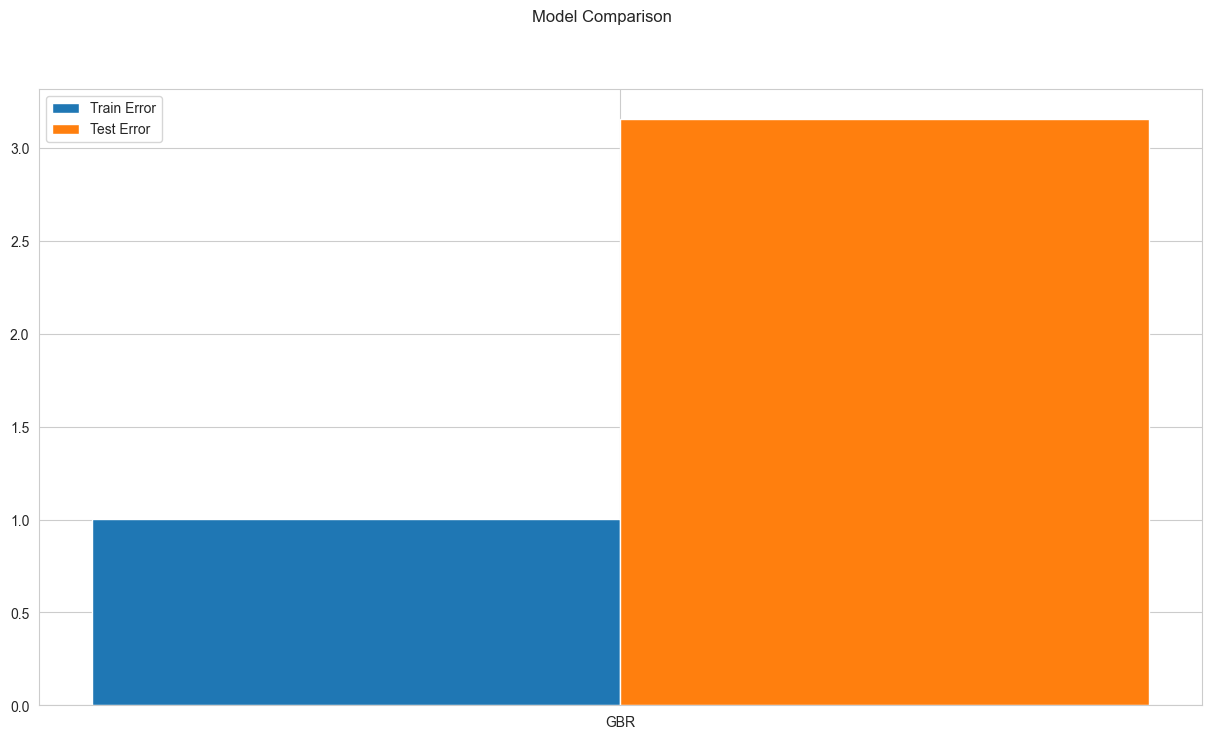

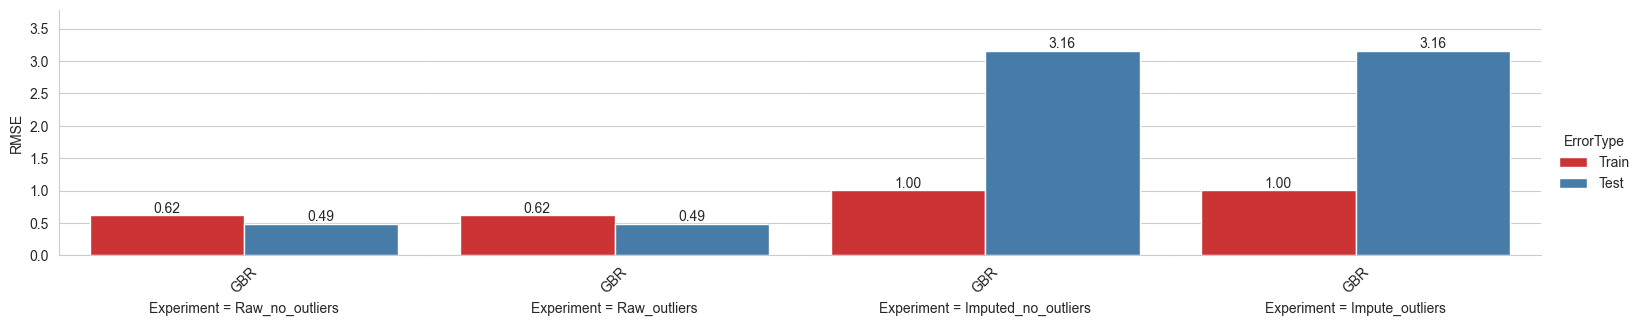


Training GBR model...
Fitting 30 folds for each of 12 candidates, totalling 360 fits
[LightGBM] [Warning] Unknown parameter: lgbmregressor__max_depth
[LightGBM] [Warning] Unknown parameter: lgbmregressor__learning_rate
[LightGBM] [Warning] Unknown parameter: lgbmregressor__n_estimators
[LightGBM] [Warning] Unknown parameter: lgbmregressor__num_leaves

Best model: LGBMRegressor(lgbmregressor__learning_rate=0.01, lgbmregressor__max_depth=5,
              lgbmregressor__n_estimators=100, lgbmregressor__num_leaves=35,
              random_state=42)

Mean error: 0.7072661530306729

Standard error: 0.0

Residual analysis for train set:
Homoscedasticity scatter plot:
Ljung-Box test for autocorrelation in residuals:
    lb_stat  lb_pvalue
10  26.0962   0.003613
The Ljung-Box test suggests that there is autocorrelation in the residuals (p-value < 0.05).

Jarque-Bera test for normality in residuals:
Test statistic: 12961.815115446707, p-value: 0.0
The Jarque-Bera test suggests that the residual

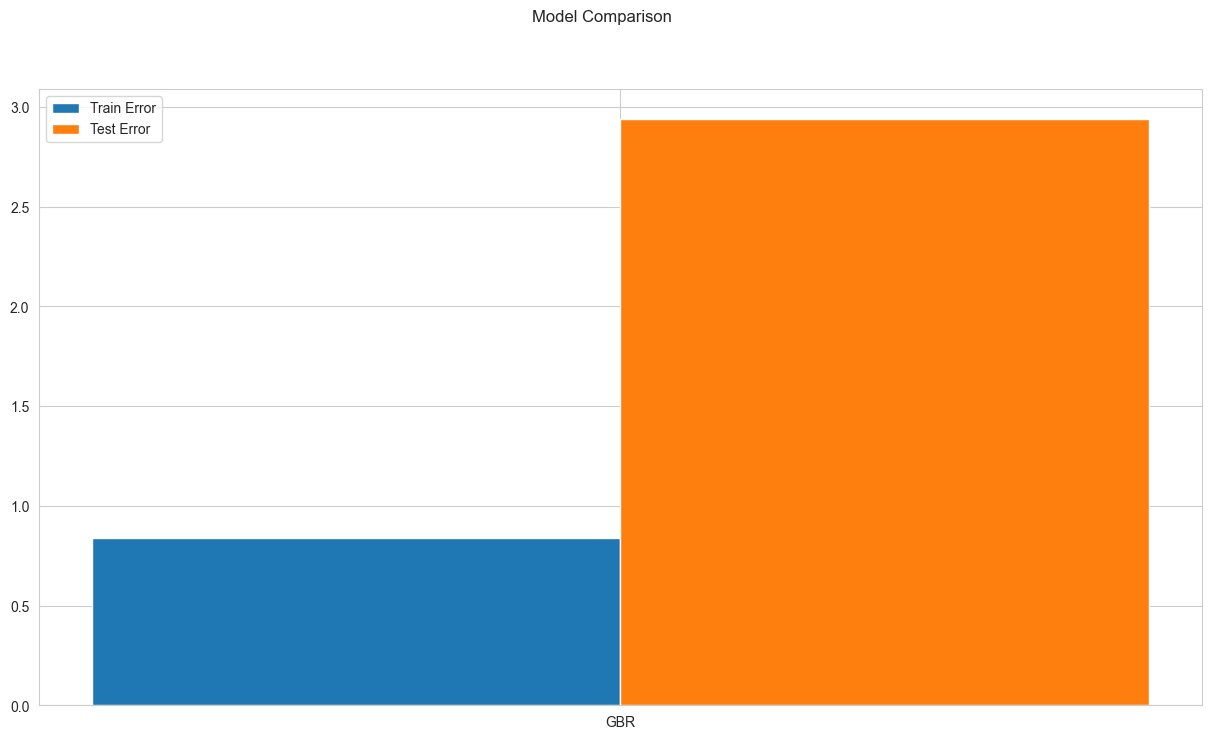

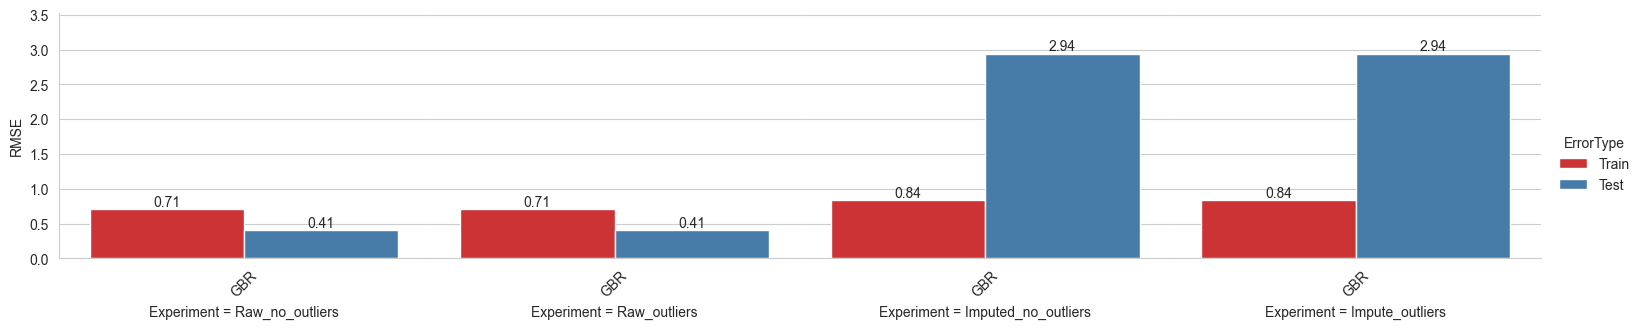


Training GBR model...
Fitting 30 folds for each of 12 candidates, totalling 360 fits
[LightGBM] [Warning] Unknown parameter: lgbmregressor__max_depth
[LightGBM] [Warning] Unknown parameter: lgbmregressor__learning_rate
[LightGBM] [Warning] Unknown parameter: lgbmregressor__n_estimators
[LightGBM] [Warning] Unknown parameter: lgbmregressor__num_leaves

Best model: LGBMRegressor(lgbmregressor__learning_rate=0.01, lgbmregressor__max_depth=5,
              lgbmregressor__n_estimators=100, lgbmregressor__num_leaves=35,
              random_state=42)

Mean error: 0.6968128267335447

Standard error: 0.0

Residual analysis for train set:
Homoscedasticity scatter plot:
Ljung-Box test for autocorrelation in residuals:
      lb_stat  lb_pvalue
10  38.434872   0.000032
The Ljung-Box test suggests that there is autocorrelation in the residuals (p-value < 0.05).

Jarque-Bera test for normality in residuals:
Test statistic: 14139.778022927503, p-value: 0.0
The Jarque-Bera test suggests that the resi

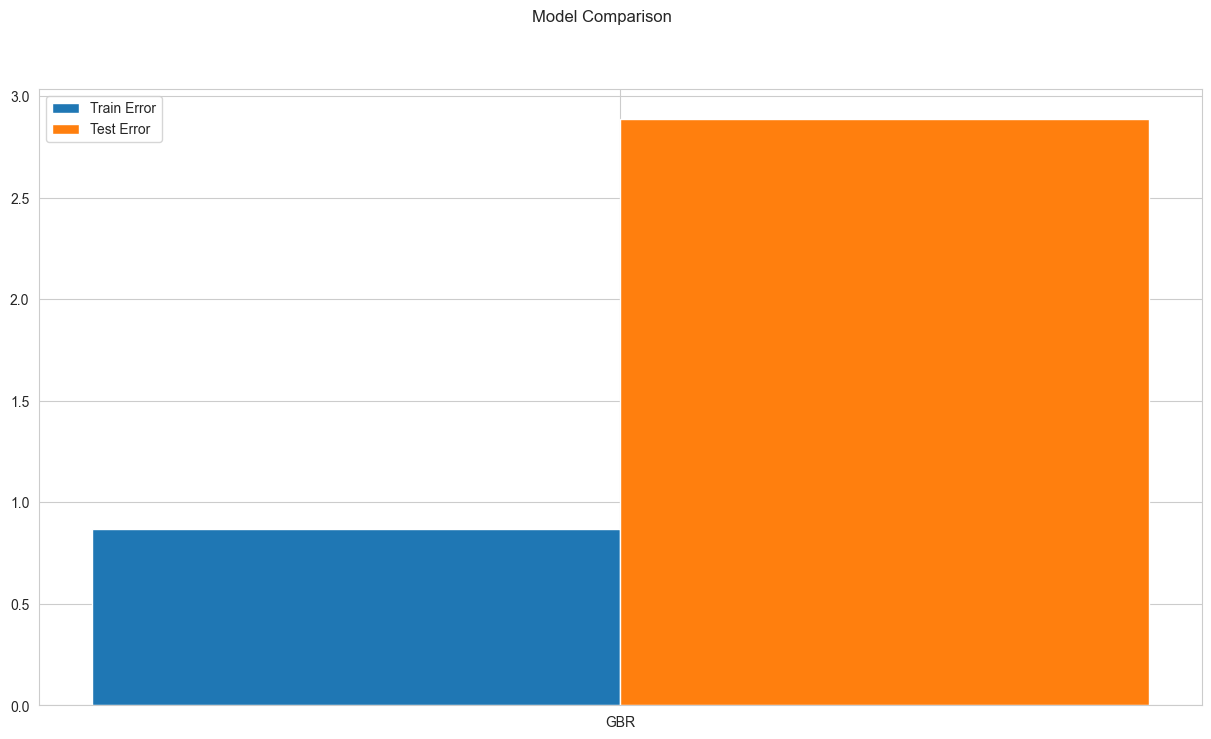

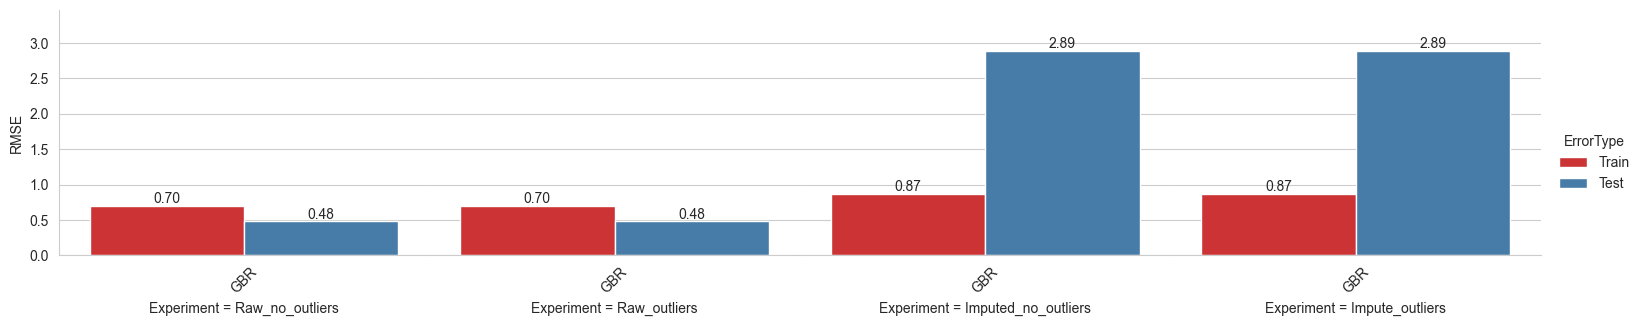


Training GBR model...
Fitting 30 folds for each of 12 candidates, totalling 360 fits
[LightGBM] [Warning] Unknown parameter: lgbmregressor__max_depth
[LightGBM] [Warning] Unknown parameter: lgbmregressor__learning_rate
[LightGBM] [Warning] Unknown parameter: lgbmregressor__n_estimators
[LightGBM] [Warning] Unknown parameter: lgbmregressor__num_leaves

Best model: LGBMRegressor(lgbmregressor__learning_rate=0.01, lgbmregressor__max_depth=5,
              lgbmregressor__n_estimators=100, lgbmregressor__num_leaves=35,
              random_state=42)

Mean error: 0.6427506421927697

Standard error: 7.450580596923828e-09

Residual analysis for train set:
Homoscedasticity scatter plot:
Ljung-Box test for autocorrelation in residuals:
      lb_stat  lb_pvalue
10  13.899219   0.177638
The Ljung-Box test suggests that there is no significant autocorrelation in the residuals (p-value >= 0.05).

Jarque-Bera test for normality in residuals:
Test statistic: 393.2509549365417, p-value: 4.042407899752

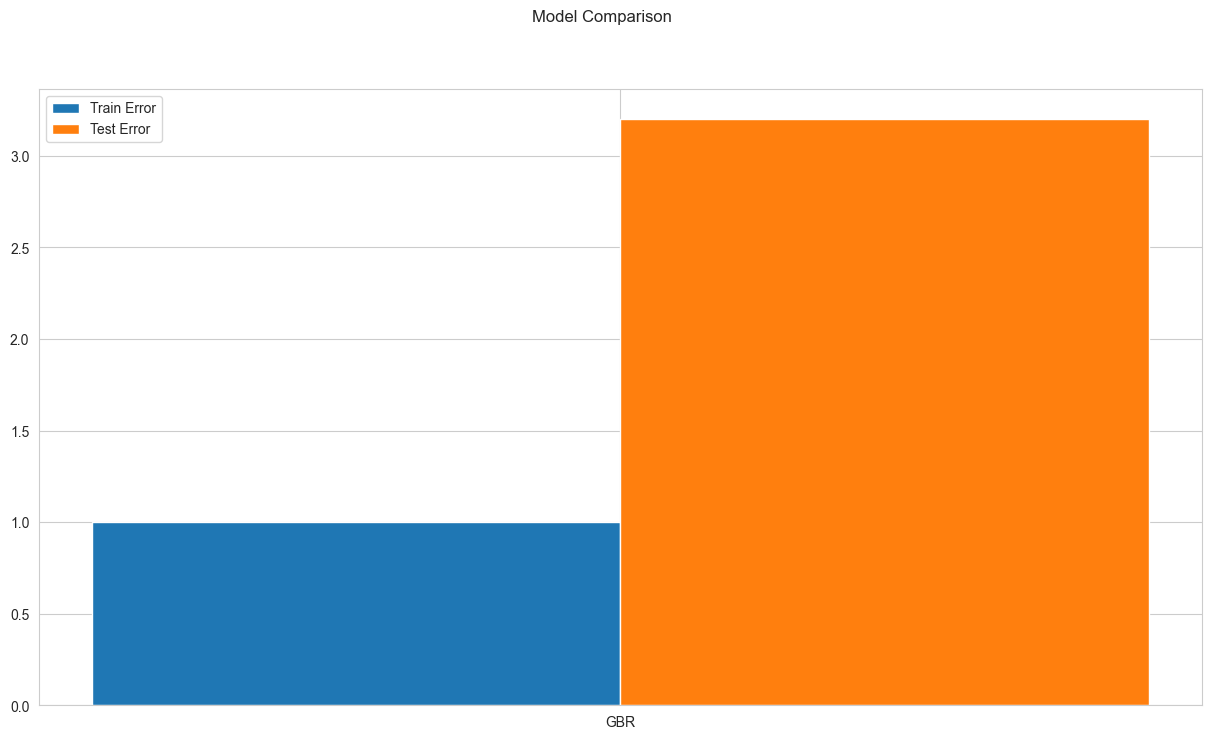

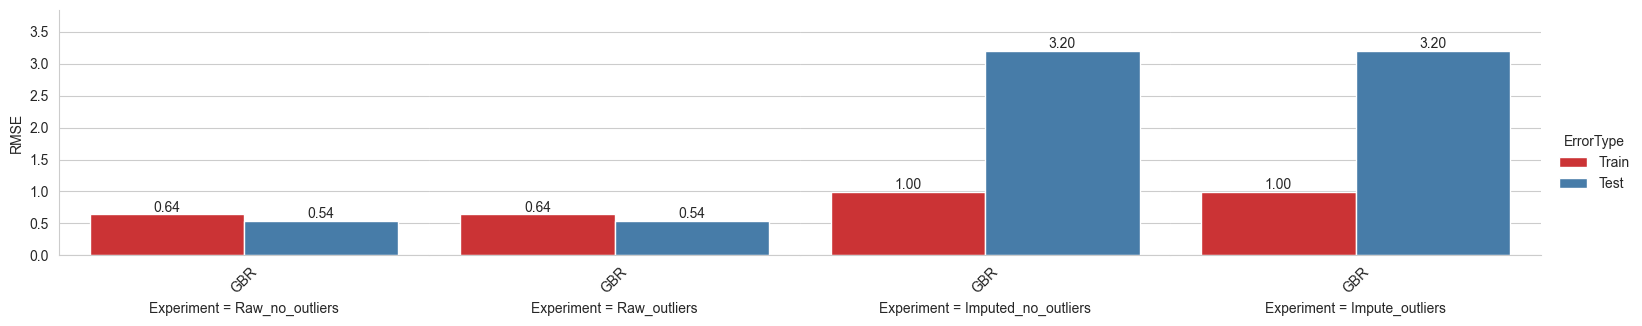